In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from skimage.feature import match_template
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools

## Load Dataset

This is just a small toy dataset for explosion vs earthquake discrimination. I'm not even sure if the labels are all correct, I just needed some labeled waveforms for this demo.

In [2]:
def read_cat(cat_file):
    cat = pd.read_csv(cat_file, index_col=0)
    cat['TIME'] = pd.to_datetime(cat['TIME'])
    return cat

cat = read_cat("cat_DUG_sm4.csv")
dat = np.load('dat_DUG_sm4.npy')
fs = 40 # sample rate of waveforms in Hz

<img src="dataset_map.png" width="800px">

In [4]:
cat.Y.value_counts()

1    10
0    10
Name: Y, dtype: int64

## Compute the scalograms:

Here is the CWT code from obspy.

In [5]:
def cwt(st, dt, w0, fmin, fmax, nf=100):
    """
    Continuous Wavelet Transformation using the Morlet wavelet.
    :param st: time dependent signal.
    :param dt: time step between two samples in st (in seconds)
    :param w0: parameter for the wavelet, tradeoff between time and frequency resolution
    :param fmin: minimum frequency (in Hz)
    :param fmax: maximum frequency (in Hz)
    :param nf: number of logarithmically spaced frequencies between fmin and fmax
    :return: time frequency representation of st, type numpy.ndarray of complex values, shape = (nf, len(st)).
    """
    
    npts = len(st) * 2
    tmax = (npts - 1) * dt
    t = np.linspace(0., tmax, npts)
    f = np.logspace(np.log10(fmin), np.log10(fmax), nf)

    cwt = np.zeros((npts // 2, nf), dtype=np.complex)


    def psi(t):
        return np.pi ** (-.25) * np.exp(1j * w0 * t) * np.exp(-t ** 2 / 2.)

    def scale(f):
        return w0 / (2 * np.pi * f)

    def next_pow_2(i):
        return int(math.pow(2, math.ceil(math.log(i) / math.log(2))))

    nfft = next_pow_2(npts) * 2
    sf = np.fft.fft(st, n=nfft)

    # Ignore underflows.
    with np.errstate(under="ignore"):
        for n, _f in enumerate(f):
            a = scale(_f)
            # time shift necessary, because wavelet is defined around t = 0
            psih = psi(-1 * (t - t[-1] / 2.) / a).conjugate() / np.abs(a) ** .5
            psihf = np.fft.fft(psih, n=nfft)
            tminin = int(t[-1] / 2. / (t[1] - t[0]))
            cwt[:, n] = np.fft.ifft(psihf * sf)[tminin:tminin + npts // 2] * (t[1] - t[0])

    return cwt.T

def scalogram_3C(data, w0, fs, fmin=1, fmax=None, nf=100):
    """
    Compute Scalogram for 3-component waveform data.
    :param data: 3-component time dependent signal of shape (:, 3)
    :param w0: parameter for the wavelet, tradeoff between time and frequency resolution
    :param fs: sample rate of signal in Hz
    :param fmin: minimum frequency (in Hz), defaults to .1
    :param fmax: maximum frequency (in Hz), defaults to Nyquist
    :param nf: number of logarithmically spaced frequencies between fmin and fmax
    :return: normalized 3-component scalogram of shape = (nf, len(st), 3).
    """
    
    if fmax is None:
        fmax = fs/2
    
    scalogram = []
    for i in range(3):
        scalogram.append(np.abs(cwt(data[:,i], 1/fs, 8, fmin, fmax))[::-1])

    scalogram = np.stack(scalogram, -1)
    scalogram = scalogram/scalogram.max()
    
    return scalogram

In [6]:
# Select all explosions and create scalogram embeddings
my_pos_cat = cat.loc[cat.Y == 1]
my_pos_dat = dat[my_pos_cat.index.values]
my_pos_emb = []

for i in range(len(my_pos_dat)):
    my_pos_emb.append(scalogram_3C(my_pos_dat[i], 8, fs, fmax=10))
    
my_pos_emb = np.stack(my_pos_emb)


# Select all earthquakes and create scalogram embeddings
my_neg_cat = cat.loc[cat.Y == 0]
my_neg_dat = dat[my_neg_cat.index.values]
my_neg_emb = []

for i in range(len(my_neg_dat)):
    my_neg_emb.append(scalogram_3C(my_neg_dat[i], 8, fs, fmax=10))
    
my_neg_emb = np.stack(my_neg_emb)

### Visualize Explosions

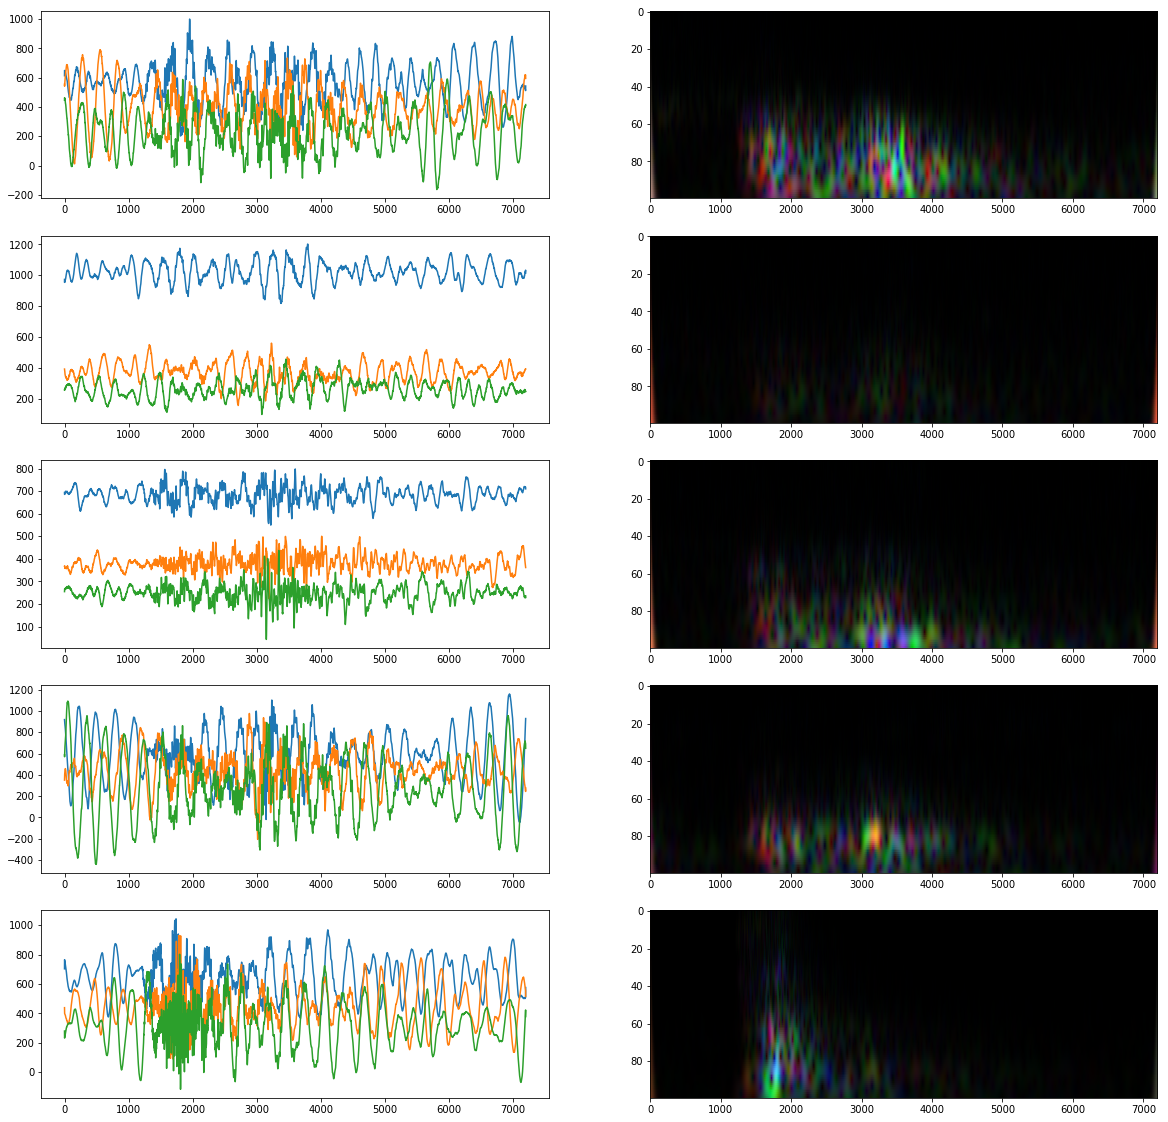

In [7]:
nb_examples = 5
fig, ax = plt.subplots(nb_examples, 2, figsize=(20,20))

for i in range(nb_examples):
    ax[i, 0].plot(  my_pos_dat[i])
    ax[i, 1].imshow(my_pos_emb[i], aspect='auto')

### Visualize Earthquakes

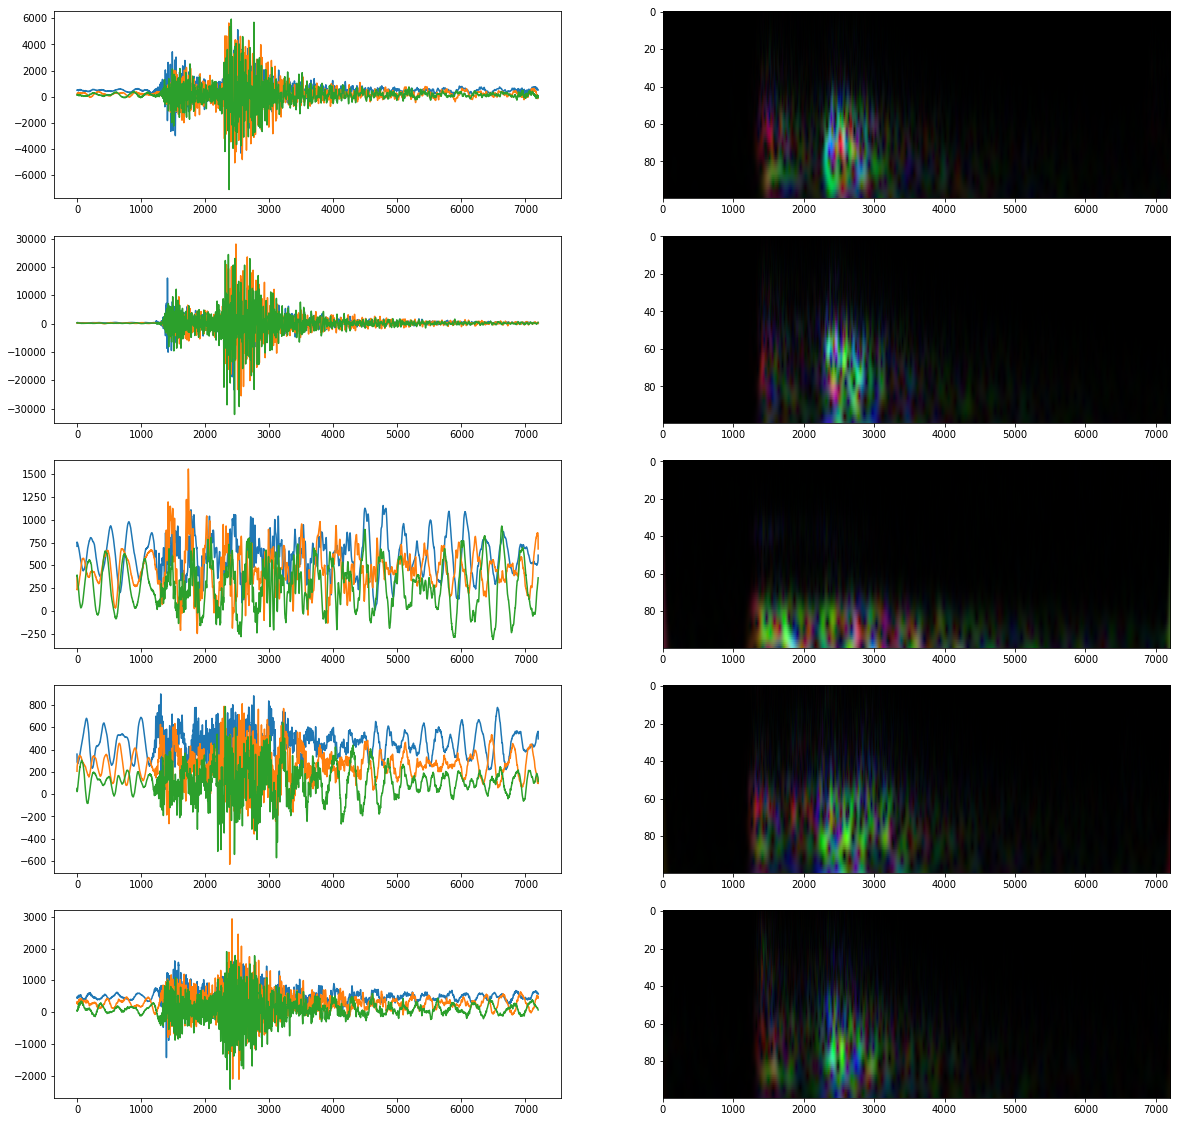

In [8]:
nb_examples = 5
fig, ax = plt.subplots(nb_examples, 2, figsize=(20,20))

for i in range(nb_examples):
    ax[i, 0].plot(  my_neg_dat[i])
    ax[i, 1].imshow(my_neg_emb[i], aspect='auto')

## Perform Template Matching

#### Generate a dataframe of correlation scores for all possible pairs

In [9]:
#put together a composite catalog and align indices with the waveform and scalogram numpy arrays
my_cat = pd.concat([my_pos_cat, my_neg_cat]).reset_index(drop=True)
my_emb = np.vstack([my_pos_emb, my_neg_emb])
my_dat = np.vstack([my_pos_dat, my_neg_dat])

In [10]:
# find all possible pairs and annotate by event (EVENTID) and source type (Y)
df = pd.DataFrame(list(itertools.combinations(range(len(my_cat)), 2)), columns = ['idx_1', 'idx_2'])
df[['EVID_1', 'Y_1']] = df.join(my_cat, on='idx_1')[['EVENTID', 'Y']]
df[['EVID_2', 'Y_2']] = df.join(my_cat, on='idx_2')[['EVENTID', 'Y']]

# Create placeholder column for the correlation scores
df['Score'] = ''

In [11]:
# Iterate through the dataframe and calculate the correlation scores for each pair
for i, row in df.iterrows():
    score = match_template(my_emb[row.idx_1,:,:,0], my_emb[row.idx_2,:,:,0])[0][0]
    df.at[i, 'Score'] = score
    print(i, row.idx_1, row.idx_2, row.Y_1 == row.Y_2, score)

0 0 1 True 0.5062069094173408
1 0 2 True 0.7411591856245959
2 0 3 True 0.7487315667381865
3 0 4 True 0.5997915542429877
4 0 5 True 0.47574064933602955
5 0 6 True 0.8437650920748662
6 0 7 True 0.3290325268992476
7 0 8 True 0.7653870843561921
8 0 9 True 0.46584967463196664
9 0 10 False 0.4359446705638995
10 0 11 False 0.3920875889299757
11 0 12 False 0.6497329640522711
12 0 13 False 0.5251628931481982
13 0 14 False 0.49479839198302
14 0 15 False 0.4301581872321308
15 0 16 False 0.46069078017719006
16 0 17 False 0.4419178348021785
17 0 18 False 0.48046990643114257
18 0 19 False 0.5933276026387114
19 1 2 True 0.7815194453150408
20 1 3 True 0.4876808078454259
21 1 4 True 0.4775604300877728
22 1 5 True 0.16823693162473963
23 1 6 True 0.3568463344097778
24 1 7 True 0.4451885917804773
25 1 8 True 0.5493982537046546
26 1 9 True 0.4981670710074733
27 1 10 False 0.1411367118269712
28 1 11 False 0.12008190938266593
29 1 12 False 0.3821001513444923
30 1 13 False 0.26542822737269756
31 1 14 False 0.

#### Find max pos/neg correlation for each entry

In [12]:
# add placeholder columns for the positive, negative and composite correlation scores

my_cat['pos_score'] = ''
my_cat['neg_score'] = ''
my_cat['comp_score'] = ''

# Iterate through the catalog and add the positive, negative and composite correlation scores
for i, row in my_cat.iterrows():

    # For each event in the catalog, select ALL its correlation scores for the correlation datafram
    # Split these scores between matching and non-matching templates
    # Find the maximum correlation scores for the pos and neg cases (these could be matches, if event is pos
    # or non-matches, if the event is neg)
    
    my_df_match = df.loc[((df.idx_1 == i) | (df.idx_2 == i)) & (df.Y_1 == df.Y_2)]
    my_df_miss = df.loc[((df.idx_1 == i) | (df.idx_2 == i)) & (df.Y_1 != df.Y_2)]
    if row.Y == 1:
        my_cat.at[i, 'pos_score'] = my_df_match.Score.max()
        my_cat.at[i, 'neg_score'] = my_df_miss.Score.max()
    else:
        my_cat.at[i, 'neg_score'] = my_df_match.Score.max()
        my_cat.at[i, 'pos_score'] = my_df_miss.Score.max()
    my_cat.at[i, 'comp_score'] = my_cat.at[i, 'pos_score']/my_cat.at[i, 'neg_score'] + 2*my_cat.at[i, 'pos_score']

In [13]:
my_cat

,EVENTID,REPORTER,STA,LAT,LON,ELEV,CHN,DIST,BAZ,ISCPHASE,...,LAT_1,LON_1,DEPTH,AUTHOR_1,TYPE,MAG,Y,pos_score,neg_score,comp_score
0,13336032,NaN,DUG,40.195,-112.8133,1477,BHZ,2.82,105.2,Pn,...,40.9893,-116.3709,0.0,NaN,NaN,NaN,1,0.843765,0.649733,2.98616
1,17173654,NaN,DUG,40.195,-112.8133,1477,???,2.95,106.2,Pn,...,41.0819,-116.5154,0.0,IDC,ML,2.2,1,0.781519,0.3821,3.60837
2,13681187,NaN,DUG,40.195,-112.8133,1477,???,2.92,106.2,Pn,...,41.0673,-116.4697,0.0,NaN,NaN,NaN,1,0.781519,0.637071,2.78978
3,11507453,NaN,DUG,40.195,-112.8133,1477,BHZ,2.85,104.8,Pn,...,40.9778,-116.4098,0.0,ISC,mb,2.9,1,0.748732,0.601137,2.74299
4,16111525,NaN,DUG,40.195,-112.8133,1477,???,0.64,234.4,Pg,...,40.5676,-112.1388,0.0,NaN,NaN,NaN,1,0.608985,0.554919,2.3154
5,13199973,NaN,DUG,40.195,-112.8133,1477,???,1.54,299.7,Pn,...,39.4450,-111.0681,0.0,ISC,mb,4.2,1,0.499915,0.713889,1.7001
6,13260867,NaN,DUG,40.195,-112.8133,1477,???,2.84,104.4,Pn,...,40.9580,-116.4076,0.0,NaN,NaN,NaN,1,0.843765,0.579486,3.14359
7,17179072,NaN,DUG,40.195,-112.8133,1477,???,1.27,159.2,Pb,...,41.3795,-113.4005,0.0,NEIC,ML,1.9,1,0.694374,0.491776,2.80072
8,11685363,NaN,DUG,40.195,-112.8133,1477,???,2.64,100.8,Pn,...,40.7405,-116.1946,0.0,NEIC,ML,2.5,1,0.765387,0.62044,2.76439
9,17177739,NaN,DUG,40.195,-112.8133,1477,???,0.89,174.9,Pn,...,41.0798,-112.9151,0.0,NaN,NaN,NaN,1,0.694374,0.5792,2.5876


#### Visualize the added seperability from including the negative tempates

You can see that the data are not linearly seperable, however, they are more seperable when you add the dimensionality of the negative scores.|

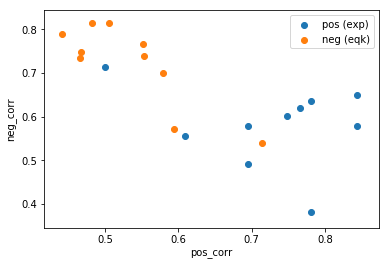

In [16]:
plt.scatter(my_cat.loc[my_cat.Y == 1].pos_score, my_cat.loc[my_cat.Y == 1].neg_score, label='pos (exp)')
plt.scatter(my_cat.loc[my_cat.Y == 0].pos_score, my_cat.loc[my_cat.Y == 0].neg_score, label='neg (eqk)')
plt.xlabel('pos_corr')
plt.ylabel('neg_corr')
plt.legend()

Plotting the ROC curves, you can clearly see the advantage of adding the negative templates to the discrimination

pos__neg_roc_auc 0.93
positive_roc_auc 0.91


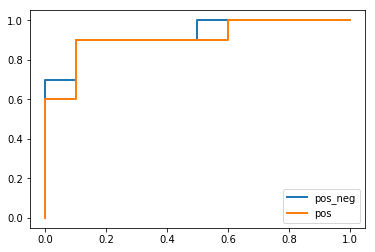

In [15]:
fpr, tpr, th = roc_curve(my_cat.Y, my_cat.comp_score/2 + my_cat.pos_score)
roc_auc = auc(fpr, tpr)
print('pos__neg_roc_auc', roc_auc)
plt.plot(fpr, tpr, lw=2, label='pos_neg')

fpr, tpr, th = roc_curve(my_cat.Y, my_cat.pos_score)
roc_auc = auc(fpr, tpr)
print('positive_roc_auc', roc_auc)
plt.plot(fpr, tpr, lw=2, label='pos')

plt.legend()